## Selective Search Example
- Ref
1. https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/
2. https://www.pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/

In [107]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [108]:
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

### Parameter

In [109]:
# Image Data
FPATH = './drive/My Drive/Colab Notebooks/1.jpg'

# Selective Search
OPTION = 'quality' # or 'quality'

# Object classification
BOX_SIZE_TH = 0.1
CONF_TH = 0.95
NMS_TH = 0.5

### Prepare Input Data

In [110]:
# read image
im = cv2.imread(FPATH)

### Selective Search based on OpenCV

In [111]:
# create selective search segmentation object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set input image
ss.setBaseImage(im)

# switch option (should be after setBaseImage)
if OPTION == 'fast':
    ss.switchToSelectiveSearchFast()
else:
    ss.switchToSelectiveSearchQuality()

# run selective search
rects = ss.process()

### Classification based on Resnet

In [112]:
# Resnet ImageNet model
model = ResNet50()

In [113]:
# Prepare ROIs
proposals, boxes = [], []
for (x, y, w, h) in rects:
    # Skip small boxes
    if w / im.shape[1] < BOX_SIZE_TH or h / im.shape[0] < BOX_SIZE_TH:
        continue

    # Crop ROI / Preprocessing
    roi = cv2.cvtColor(im[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224, 224))
    roi = preprocess_input(img_to_array(roi))

    proposals.append(roi)
    boxes.append((x, y, w, h))

In [114]:
# Run classification for each bouding box
preds = model.predict(np.array(proposals))

In [115]:
# Decode ([#Proposals, 1000] => List of (ImageNetID, Label Text, Prob))
preds_d = imagenet_utils.decode_predictions(preds, top=1)

In [116]:
# Confidence threshold
# Store result with key = label, value = list of boxes
results = {}
for i, p in enumerate(preds_d):
    _, label, prob = p[0]
    if prob >= CONF_TH:
        box_list = results.get(label, [])
        box_list.append((boxes[i], prob))
        results[label] = box_list

### Visualization result

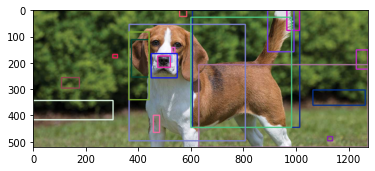

In [117]:
# Selective Search result
image_vis = im.copy()
for ind in np.random.choice(len(rects), 20, replace=False):
    x, y, w, h = rects[ind]
    color = [np.random.randint(0, 255) for j in range(3)]
    cv2.rectangle(image_vis, (x, y), (x+w, y+h), color, 3)

plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))

In [120]:
# Detection result
image_vis = im.copy()
image_vis_nms = im.copy()

for label in results.keys():
    # NMS (Data type should not be np.int / np.float)
    boxes = []
    for r in results[label]:
        x, y, w, h = r[0]
        boxes.append([int(x), int(y), int(x+w-1), int(y+h-1)])
    probs = [float(r[1]) for r in results[label]]

    nms_bid = cv2.dnn.NMSBoxes(boxes, probs, CONF_TH, NMS_TH)

    # Overlay box
    for bid, (box, prob) in enumerate(zip(boxes, probs)):
        x1, y1, x2, y2 = box

        # Before NMS
        cv2.rectangle(image_vis, (x1, y1), (x2, y2), (0, 0, 255), 3)

        # After NMS
        if bid in nms_bid:
            cv2.rectangle(image_vis_nms, (x1, y1), (x2, y2), (0, 0, 255), 3)

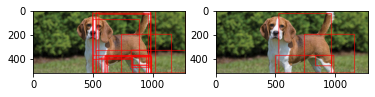

In [121]:
# Plot results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(image_vis_nms, cv2.COLOR_BGR2RGB))